In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.31 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [2]:
! pip install diffusers==0.14.0 xformers transformers scipy ftfy accelerate controlnet_aux matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.9/261.9 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.8 MB/s eta 0:00:00


In [4]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

In [5]:
using_colab = True

In [6]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aw3sh4c1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aw3sh4c1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=4522a1ec7be928f38989ed84a3e73c5412fbfaeb5a41ce521eb9b43a28c2c7b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-bly1sadq/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-06-29 05:40:26--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [7]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-seg", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
# pipe.enable_xformers_memory_efficient_attention()

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [8]:
def split_frames(video_path, output_path):
    """
    split frames of video and put into output_path folder
    """
    frame_id = 0

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    while cap.isOpened():

        # Read the video file frame by frame
        ret, frame = cap.read()

        # If 'ret' is True then 'frame' contains a valid image
        if ret:
            # You can use the 'frame' for further processing like face recognition, object detection etc.

            # Save frame as image
            cv2.imwrite(f'{output_path}/frame_{frame_id}.png', frame)
            frame_id += 1

            # Press Q on keyboard to exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break


        # Break the loop if no more frames are available
        else:
            print('no more frames!')
            break

    # Release the video capture object and close windows
    cap.release()
    cv2.destroyAllWindows()

    return frame_id

In [13]:
!mkdir frames
split_frames('/content/bladerunner2049walking.mp4','/content/frames')

mkdir: cannot create directory ‘frames’: File exists
no more frames!


183

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ax.axis('off')  # turn off the axes

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1.0]])
        img[m] = color_mask
    ax.imshow(img)
    plt.savefig('mask_bob.png', bbox_inches='tight', pad_inches=0)

    return img


In [15]:
image = cv2.imread('frames/frame_0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

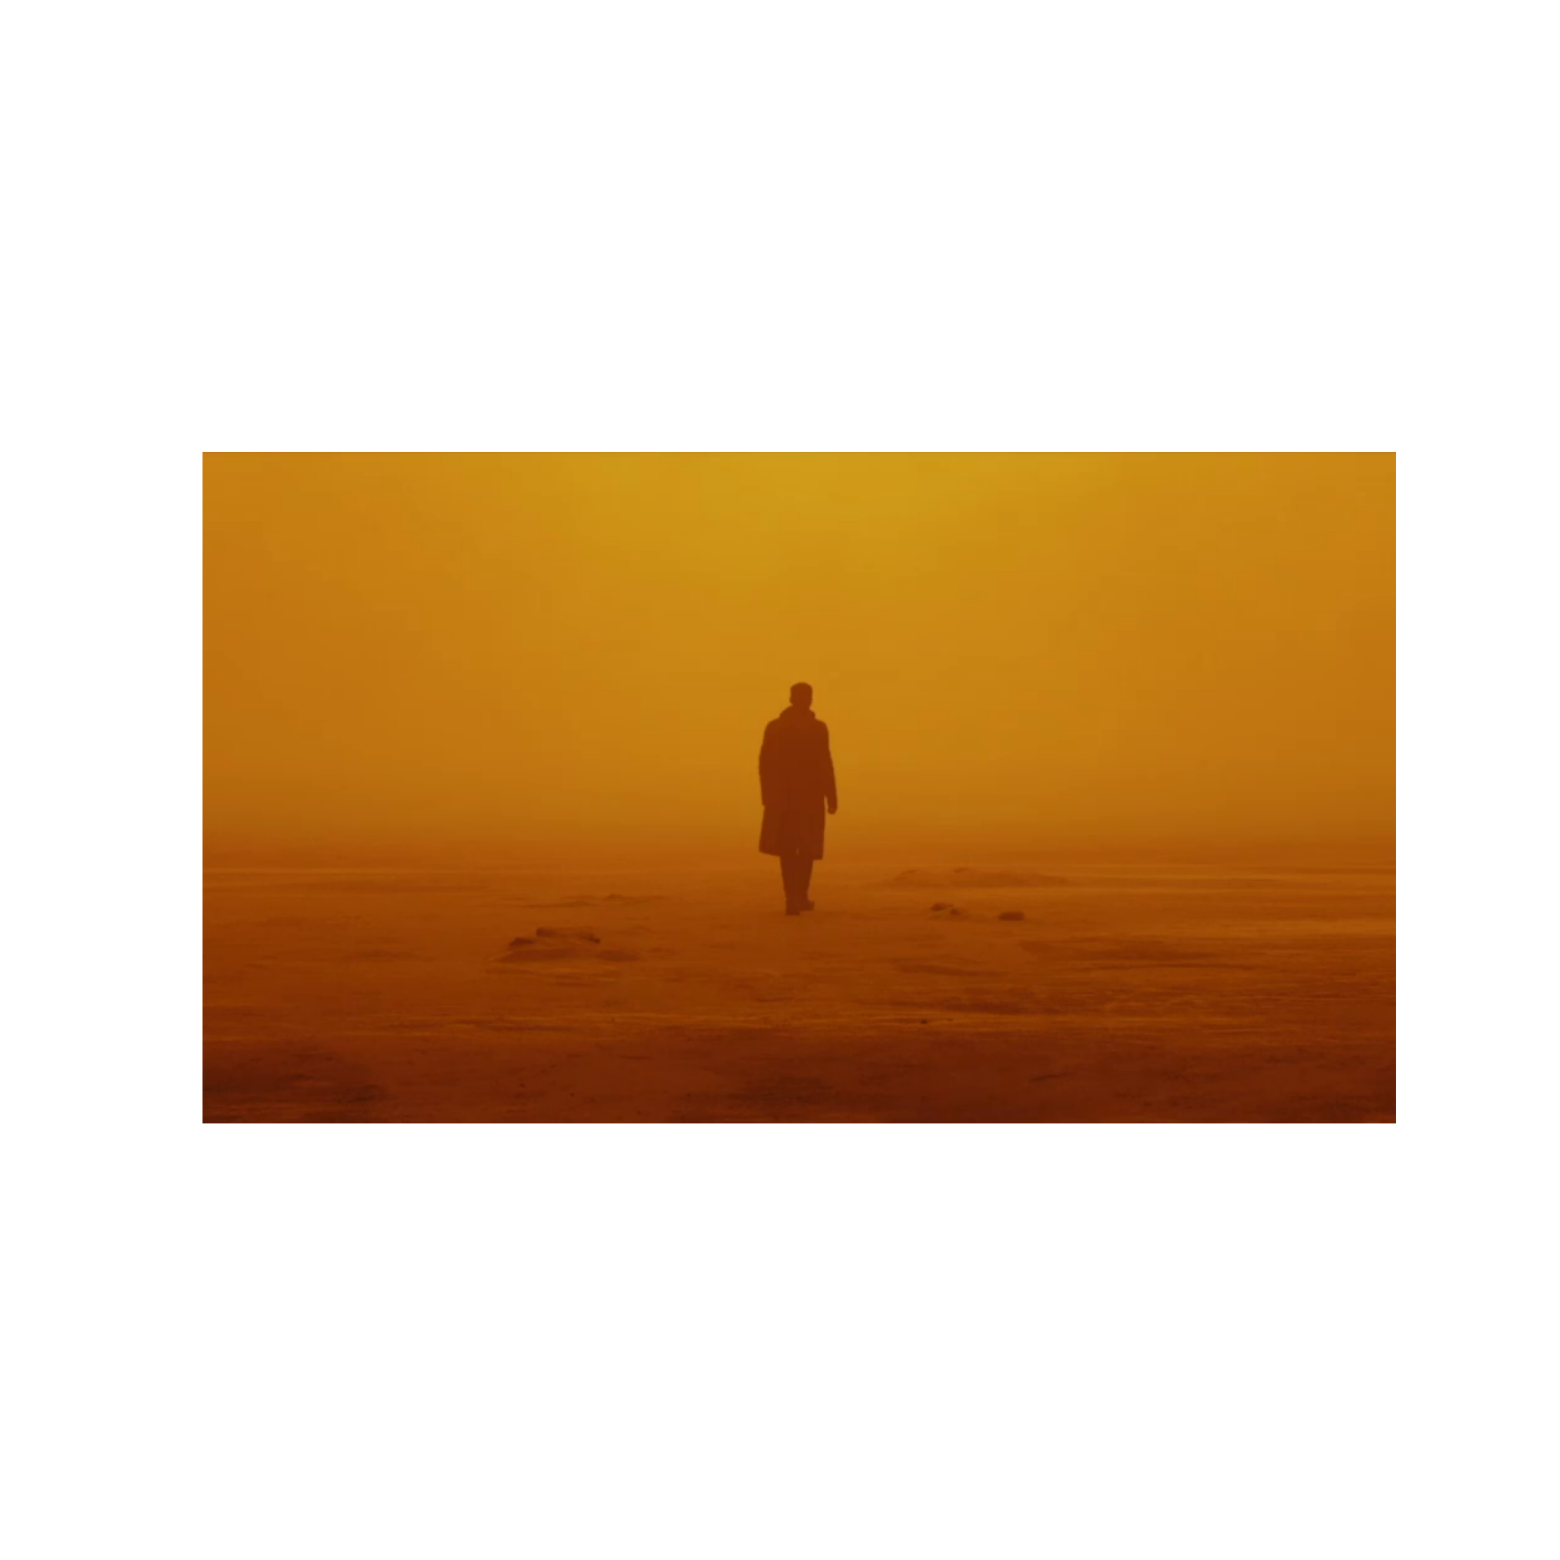

In [28]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.savefig("mask_2525.png", bbox_inches = 'tight', pad_inches = 0)

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [18]:
masks = mask_generator.generate(image)

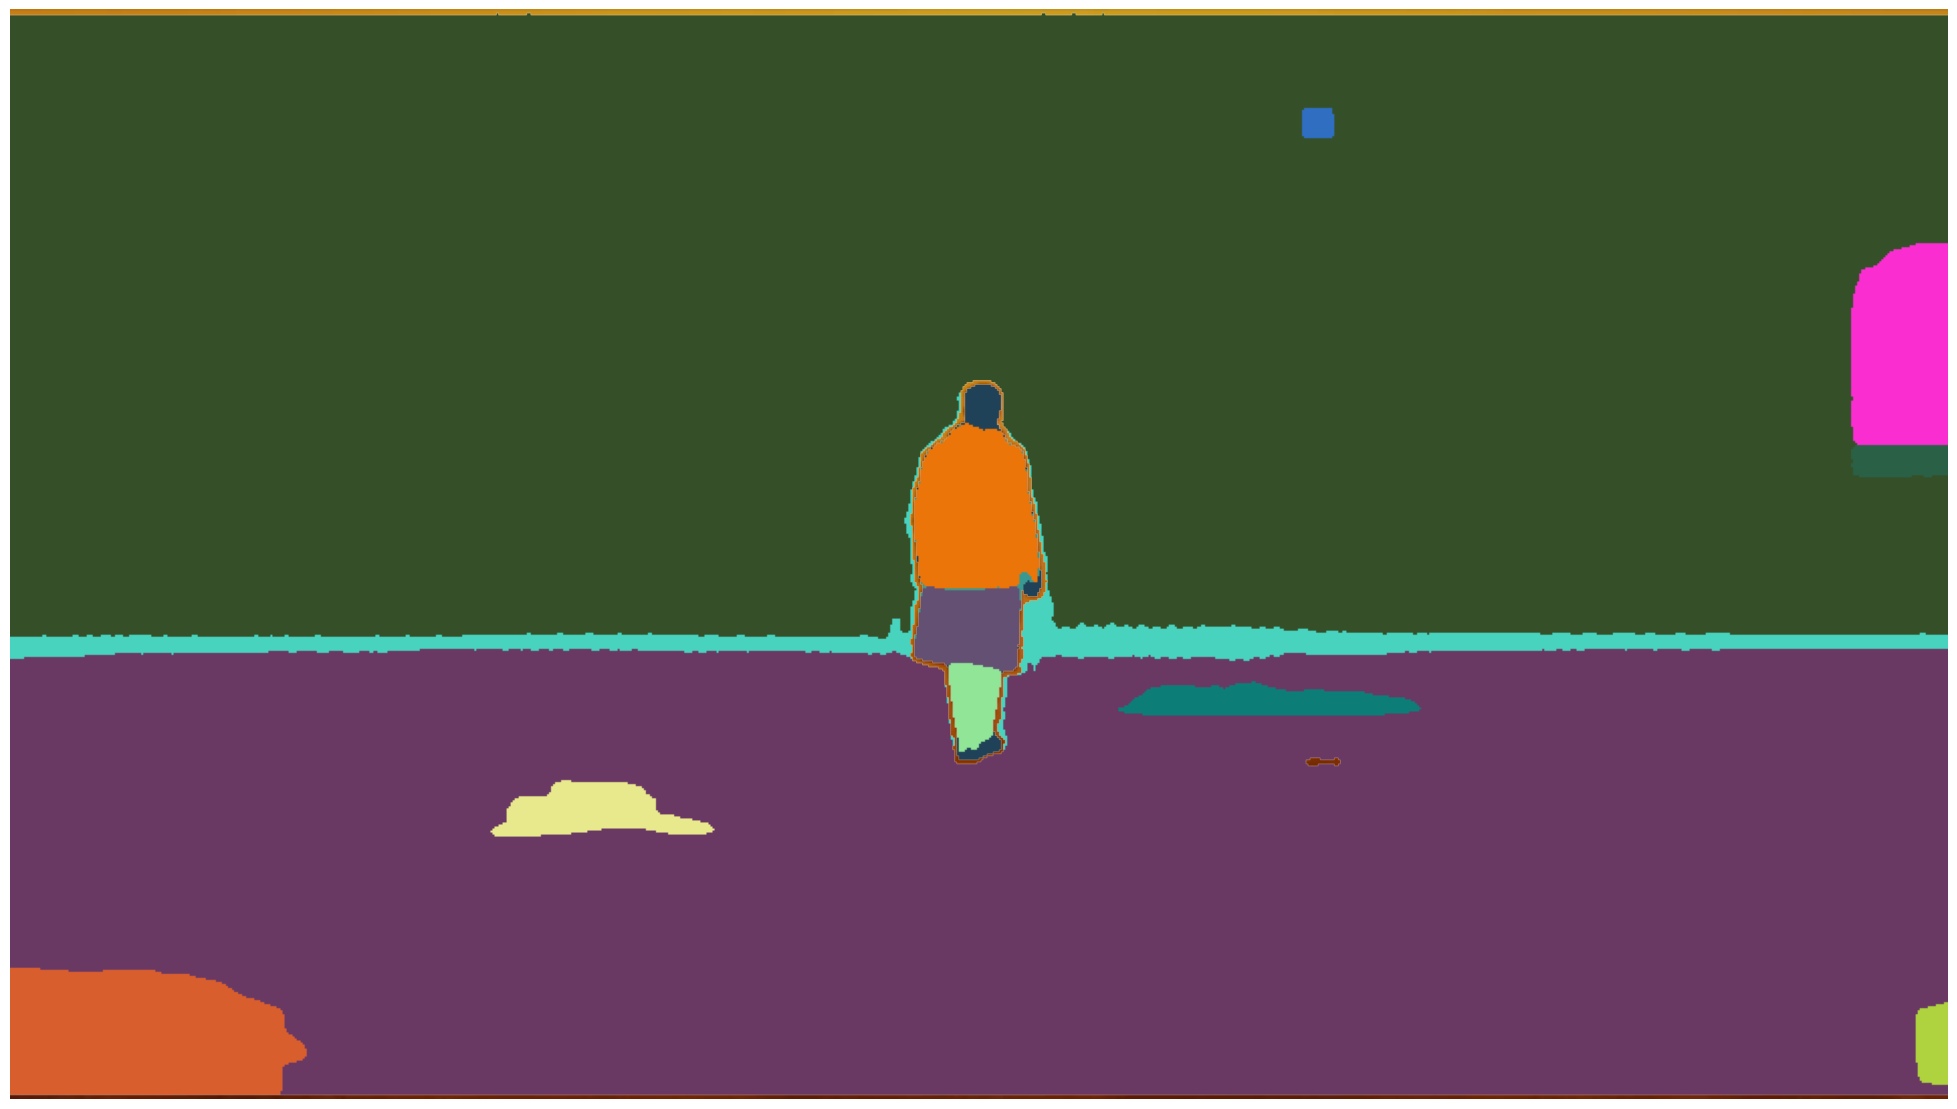

In [19]:
plt.figure(figsize=(25,25))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [35]:
from PIL import Image

# Load image
img = Image.open("frames/frame_0.png")

# Make sure the image is large enough to be cropped
assert img.size[0] >= 512 and img.size[1] >= 512, "Image is too small to be cropped to 512x512"

# Calculate dimensions for center crop
left = (img.width - 512)/2
top = (img.height - 512)/2
right = (img.width + 512)/2
bottom = (img.height + 512)/2

# Crop image
img_cropped = img.crop((left, top, right, bottom))

# Save the cropped image
img_cropped.save("og_cropped.png")
print("done!")

done!


In [36]:
from PIL import Image

# Load image
img = Image.open("mask_bob.png")

# Make sure the image is large enough to be cropped
assert img.size[0] >= 512 and img.size[1] >= 512, "Image is too small to be cropped to 512x512"

# Calculate dimensions for center crop
left = (img.width - 512)/2
top = (img.height - 512)/2
right = (img.width + 512)/2
bottom = (img.height + 512)/2

# Crop image
img_cropped = img.crop((left, top, right, bottom))

# Save the cropped image
img_cropped.save("seg_cropped.png")
print("done!")

done!


In [37]:
house_real_image=load_image("/content/og_cropped.png")
seg_image=load_image("/content/seg_cropped.png")
print(house_real_image.size,seg_image.size)
house_mask=np.zeros((*seg_image.size,3),dtype='uint8')
house_mask[50:400,-350:,:]=255
house_mask=Image.fromarray(house_mask)

(512, 512) (512, 512)


  0%|          | 0/20 [00:00<?, ?it/s]

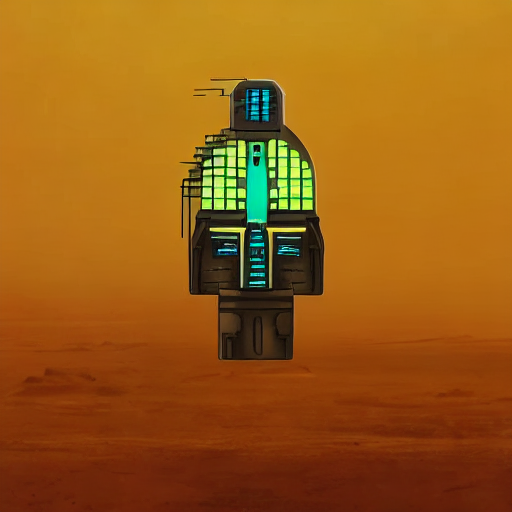

In [38]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a techno desert spaceship",
    num_inference_steps=20,
    generator=generator,
    image=house_real_image,
    control_image=seg_image,
    mask_image=house_mask
).images[0]

new_image